In [1]:
!pip install --upgrade pip
!pip install -q efficientnet

In [2]:
import numpy as np 
import pandas as pd

import time
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet101, ResNet101V2, VGG16, VGG19
from efficientnet.tfkeras import EfficientNetB7, EfficientNetL2

from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
print(tf.__version__)

2.4.1


In [4]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [5]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


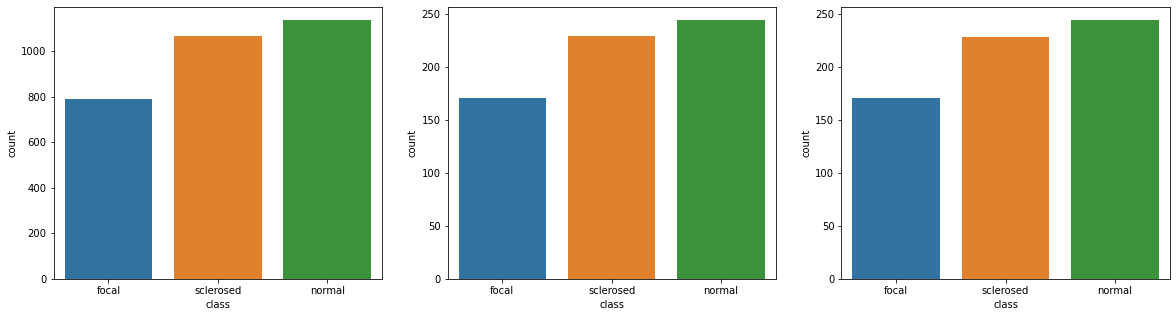

In [6]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [7]:
BUFFER_SIZE = len(train_folders)

BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
IMG_SIZE = 150

In [8]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [9]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_folders,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=BUFFER_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_SIZE, IMG_SIZE))

validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                              shuffle=BUFFER_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              class_mode='categorical', 
                                                              target_size=(IMG_SIZE, IMG_SIZE))

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.


In [10]:
test_datagen = ImageDataGenerator( rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
test_generator = test_datagen.flow_from_directory(test_folders,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=BUFFER_SIZE,
                                                   class_mode='categorical',
                                                   target_size=(IMG_SIZE, IMG_SIZE))

Found 643 images belonging to 3 classes.


In [11]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'focal': 0, 'normal': 1, 'sclerosed': 2}
{0: 'focal', 1: 'normal', 2: 'sclerosed'}


In [12]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


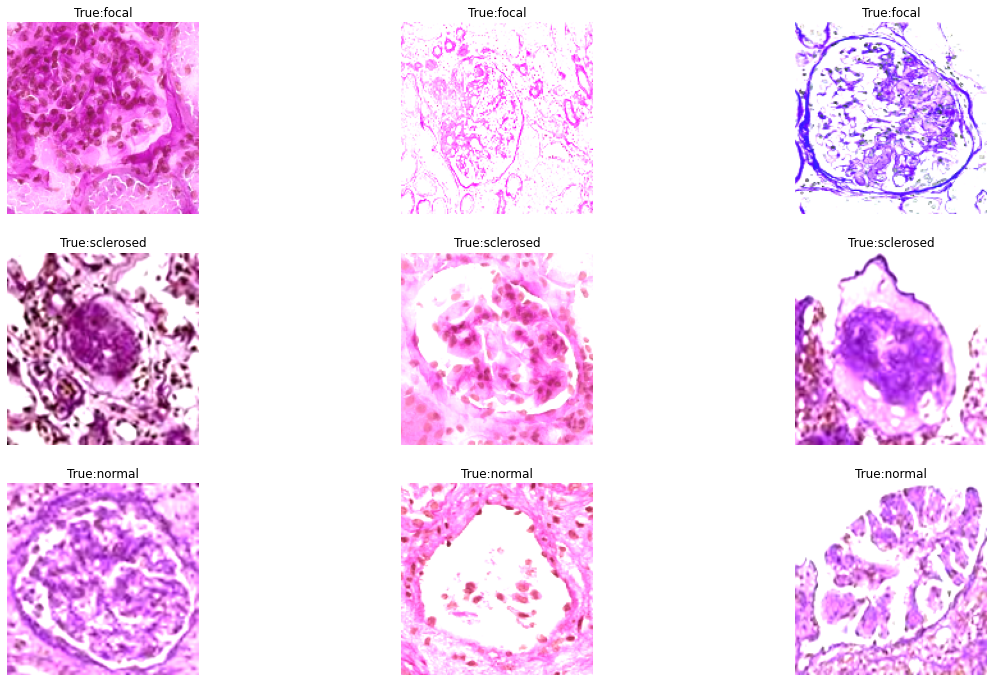

In [13]:
show_few_images(3,None)

In [14]:
#tf.keras.backend.clear_session()

# epoch config
EPOCH = 60

## VGG16

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        

47/47 [==============================] - 10s 221ms/step - loss: 0.1422 - acc: 0.9524 - val_loss: 0.2470 - val_acc: 0.9019
Epoch 26/60
47/47 [==============================] - 11s 225ms/step - loss: 0.1447 - acc: 0.9504 - val_loss: 0.2673 - val_acc: 0.9019
Epoch 27/60
47/47 [==============================] - 11s 233ms/step - loss: 0.1488 - acc: 0.9517 - val_loss: 0.2602 - val_acc: 0.8988
Epoch 28/60
47/47 [==============================] - 11s 225ms/step - loss: 0.1407 - acc: 0.9549 - val_loss: 0.2543 - val_acc: 0.9019
Epoch 29/60
47/47 [==============================] - 11s 231ms/step - loss: 0.1189 - acc: 0.9623 - val_loss: 0.2747 - val_acc: 0.9003
Epoch 30/60
47/47 [==============================] - 11s 225ms/step - loss: 0.1214 - acc: 0.9590 - val_loss: 0.2621 - val_acc: 0.9050
Epoch 31/60
47/47 [==============================] - 11s 225ms/step - loss: 0.1250 - acc: 0.9532 - val_loss: 0.2589 - val_acc: 0.9065
Epoch 32/60
47/47 [==============================] - 11s 224ms/step - loss

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


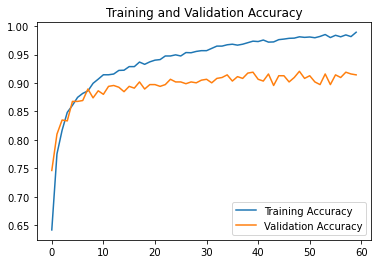

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


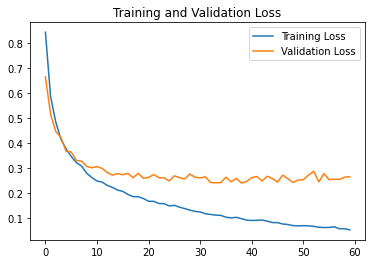

<Figure size 432x288 with 0 Axes>

In [15]:
with strategy.scope():
    vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in vgg16_model.layers:
                layers.trainable=False
    last_output = vgg16_model.layers[-1].output
    vgg_x = Flatten()(last_output)
    vgg_x = Dense(128, activation = 'relu')(vgg_x)
    vgg_x = Dense(3, activation = 'softmax')(vgg_x)
    vgg16_final_model = Model(vgg16_model.input, vgg_x)
    vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

vgg16_final_model.summary()
since = time.time()
vgg16_history = vgg16_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=vgg_early_stopping,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg16_history, 'vgg16_model')

In [16]:
vgg16_final_model.evaluate(test_generator)
vgg16_best_model = vgg16_final_model

11/11 [==============================] - 11s 1s/step - loss: 0.2909 - acc: 0.9036


## VGG19

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

47/47 [==============================] - 11s 224ms/step - loss: 0.1277 - acc: 0.9619 - val_loss: 0.2576 - val_acc: 0.9003
Epoch 33/60
47/47 [==============================] - 11s 227ms/step - loss: 0.1342 - acc: 0.9525 - val_loss: 0.2602 - val_acc: 0.9034
Epoch 34/60
47/47 [==============================] - 11s 226ms/step - loss: 0.1283 - acc: 0.9527 - val_loss: 0.2812 - val_acc: 0.9019
Epoch 35/60
47/47 [==============================] - 11s 228ms/step - loss: 0.1284 - acc: 0.9559 - val_loss: 0.2717 - val_acc: 0.8988
Epoch 36/60
47/47 [==============================] - 11s 225ms/step - loss: 0.1293 - acc: 0.9517 - val_loss: 0.2515 - val_acc: 0.9050
Epoch 37/60
47/47 [==============================] - 11s 230ms/step - loss: 0.1118 - acc: 0.9622 - val_loss: 0.2592 - val_acc: 0.9034
Epoch 38/60
47/47 [==============================] - 11s 228ms/step - loss: 0.1220 - acc: 0.9582 - val_loss: 0.2504 - val_acc: 0.9065
Epoch 39/60
47/47 [==============================] - 11s 229ms/step - loss

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


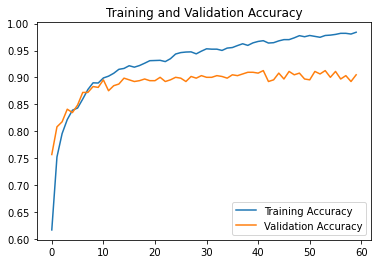

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


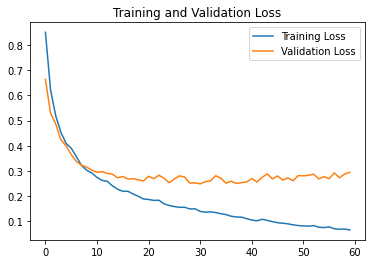

<Figure size 432x288 with 0 Axes>

In [17]:
with strategy.scope():
    vgg19_model = VGG19(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in vgg19_model.layers:
                layers.trainable=False
    last_output = vgg19_model.layers[-1].output
    vgg_x = Flatten()(last_output)
    vgg_x = Dense(128, activation = 'relu')(vgg_x)
    vgg_x = Dense(3, activation = 'softmax')(vgg_x)
    vgg19_final_model = Model(vgg19_model.input, vgg_x)
    vgg19_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

vgg19_final_model.summary()
since = time.time()
vgg19_history = vgg19_final_model.fit(train_generator, epochs = EPOCH ,validation_data = validation_generator,callbacks=vgg_early_stopping,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg19_history, 'vgg19_model')

In [18]:
vgg19_final_model.evaluate(test_generator)
vgg19_best_model = vgg19_final_model

11/11 [==============================] - 2s 165ms/step - loss: 0.2711 - acc: 0.8989


## ResNet101

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/60
INFO:tensorflow:batch_all_reduce: 420 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 420 all-reduces with algorithm = nccl, num_packs = 1
47/47 [==============================] - 63s 400ms/step - loss: 2.0581 - acc: 0.6060 - val_loss: 1989.7850 - val_acc: 0.3801
Epoch 2/60
47/47 [==============================] - 14s 299ms/step - loss: 0.3496 - acc: 0.8666 - val_loss: 603.8114 - val_acc: 0.3551
Epoch 3/60
47/47 [==============================] - 14s 298ms/step - loss: 0.2467 - acc: 0.9250 - val_loss: 1.1882 - val_acc: 0.3551
Epoch 4/60
47/47 [==============================] - 14s 299ms/step - loss: 0.0847 - acc: 0.9789 - val_loss: 1.1963 - val_acc: 0.3567
Epoch 5/60
47/47 [==============================] - 14s 301ms/step - loss: 0.0318 - acc: 0.9943 - val_loss: 1.2228 - val_acc: 0.4128
Epoch 6/60
47/47 [==============================] - 14s 301ms/step - loss: 0.0157 - acc: 0.9982 - val_loss: 1.4274 - val_acc: 0.3551
Epoch 7/60
47/47 [=====

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


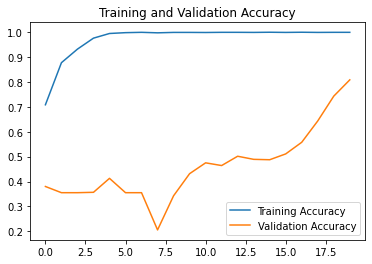

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


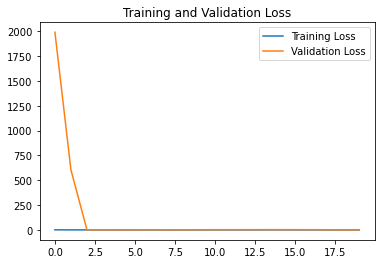

<Figure size 432x288 with 0 Axes>

In [20]:
with strategy.scope():
    ResNet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    for layers in ResNet101_model.layers:
        layers.trainable=True

    opt = SGD(lr=0.01,momentum=0.7)
    # resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
    # resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
    resnet101_x = Flatten()(ResNet101_model.output)
    resnet101_x = Dense(256,activation='relu')(resnet101_x)
    resnet101_x = Dense(3,activation='softmax')(resnet101_x)
    resnet101_x_final_model = Model(inputs=ResNet101_model.input, outputs=resnet101_x)
    resnet101_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]

resnet101_x_final_model.summary()
since = time.time()
resnet101_history = resnet101_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101_history, 'resnet101_model')

In [21]:
resnet101_x_final_model.evaluate(test_generator)
resnet101_best_model = resnet101_x_final_model

11/11 [==============================] - 23s 2s/step - loss: 0.7054 - acc: 0.8056


## ResNet101V2

171319296/171317808 [==============================] - 16s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________

Epoch 1/60
INFO:tensorflow:batch_all_reduce: 346 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 346 all-reduces with algorithm = nccl, num_packs = 1
47/47 [==============================] - 307s 4s/step - loss: 1.4631 - acc: 0.6604 - val_loss: 1.3081 - val_acc: 0.4751
Epoch 2/60
47/47 [==============================] - 13s 279ms/step - loss: 0.1531 - acc: 0.9458 - val_loss: 0.5371 - val_acc: 0.8178
Epoch 3/60
47/47 [==============================] - 13s 282ms/step - loss: 0.0817 - acc: 0.9677 - val_loss: 0.5092 - val_acc: 0.8271
Epoch 4/60
47/47 [==============================] - 13s 283ms/step - loss: 0.0235 - acc: 0.9923 - val_loss: 0.3543 - val_acc: 0.8879
Epoch 5/60
47/47 [==============================] - 13s 282ms/step - loss: 0.0431 - acc: 0.9897 - val_loss: 0.2519 - val_acc: 0.9174
Epoch 6/60
47/47 [==============================] - 14s 284ms/step - loss: 0.0360 - acc: 0.9883 - val_loss: 0.1910 - val_acc: 0.9502
Epoch 7/60
47/47 [============

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


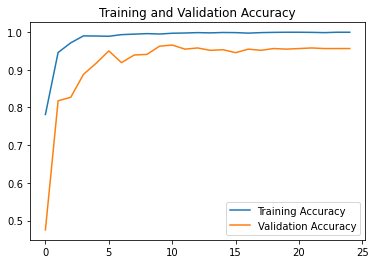

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


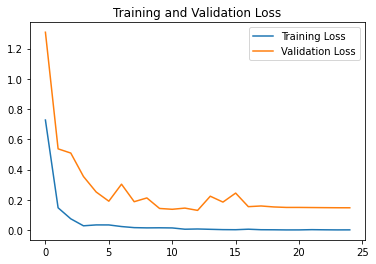

<Figure size 432x288 with 0 Axes>

In [22]:
with strategy.scope():
    ResNet101v2_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    #for layers in ResNet5v2_model.layers:
    #    layers.trainable=False

    opt = SGD(lr=0.01,momentum=0.7)
    # resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
    # resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
    resnet101v2_x = Flatten()(ResNet101v2_model.output)
    resnet101v2_x = Dense(256,activation='relu')(resnet101v2_x)
    resnet101v2_x = Dense(3,activation='softmax')(resnet101v2_x)
    resnet101v2_x_final_model = Model(inputs=ResNet101v2_model.input, outputs=resnet101v2_x)
    resnet101v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet101v2_x_final_model.summary()
since = time.time()
resnet101v2_history = resnet101v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101v2_history, 'resnet101v2_model')

In [23]:
resnet101v2_x_final_model.evaluate(test_generator)
resnet101v2_best_model = resnet101v2_x_final_model

11/11 [==============================] - 23s 2s/step - loss: 0.1634 - acc: 0.9627


## EfficientNetB7

last layer output shape:  (None, 2560)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 64)   1728        input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 64)   0           stem_bn[0][0]                    
_____________________________________________________

block6a_se_expand (Conv2D)      (None, 1, 1, 1344)   76608       block6a_se_reduce[0][0]          
__________________________________________________________________________________________________
block6a_se_excite (Multiply)    (None, 5, 5, 1344)   0           block6a_activation[0][0]         
                                                                 block6a_se_expand[0][0]          
__________________________________________________________________________________________________
block6a_project_conv (Conv2D)   (None, 5, 5, 384)    516096      block6a_se_excite[0][0]          
__________________________________________________________________________________________________
block6a_project_bn (BatchNormal (None, 5, 5, 384)    1536        block6a_project_conv[0][0]       
__________________________________________________________________________________________________
block6b_expand_conv (Conv2D)    (None, 5, 5, 2304)   884736      block6a_project_bn[0][0]         
__________

Epoch 1/60
47/47 [==============================] - 353s 5s/step - loss: 1.0945 - acc: 0.5169 - val_loss: 0.5505 - val_acc: 0.7960
Epoch 2/60
47/47 [==============================] - 11s 240ms/step - loss: 0.6331 - acc: 0.7272 - val_loss: 0.5159 - val_acc: 0.7897
Epoch 3/60
47/47 [==============================] - 11s 240ms/step - loss: 0.5930 - acc: 0.7452 - val_loss: 0.4288 - val_acc: 0.8115
Epoch 4/60
47/47 [==============================] - 11s 242ms/step - loss: 0.5229 - acc: 0.7807 - val_loss: 0.3825 - val_acc: 0.8396
Epoch 5/60
47/47 [==============================] - 11s 239ms/step - loss: 0.5166 - acc: 0.7765 - val_loss: 0.3590 - val_acc: 0.8536
Epoch 6/60
47/47 [==============================] - 11s 242ms/step - loss: 0.4636 - acc: 0.8008 - val_loss: 0.3582 - val_acc: 0.8676
Epoch 7/60
47/47 [==============================] - 12s 243ms/step - loss: 0.4565 - acc: 0.8097 - val_loss: 0.3252 - val_acc: 0.8645
Epoch 8/60
47/47 [==============================] - 12s 242ms/step - lo

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


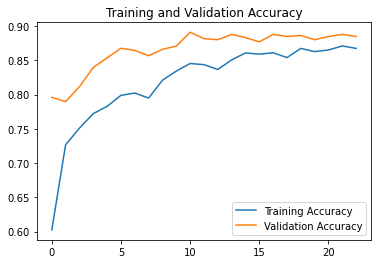

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


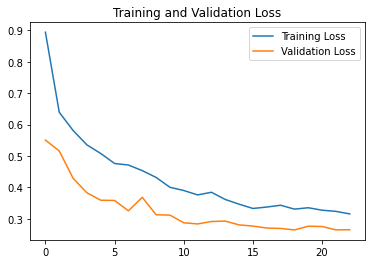

<Figure size 432x288 with 0 Axes>

In [24]:
with strategy.scope():
    effb7_model = EfficientNetB7(pooling='avg', 
                        weights='imagenet', 
                        include_top=False, 
                        input_shape=(150,150,3))
    for layers in effb7_model.layers:
                layers.trainable=False

    last_layer = effb7_model.get_layer('avg_pool')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    effb7_x = Flatten()(last_output)
    effb7_x = Dense(1024, activation = 'relu')(effb7_x)
    effb7_x = Dropout(0.2)(effb7_x)
    effb7_x = Dense(3, activation = 'softmax')(effb7_x)
    effb7_final_model = Model(effb7_model.input, effb7_x)
    effb7_final_model.compile(loss = 'categorical_crossentropy',
                              optimizer= 'adam', 
                              metrics=['acc'])

# EFFB7
effb7_final_model.summary()

reduce_lr = ReduceLROnPlateau(factor=0.5, patience=1, verbose=1, mode='min', epsilon=0.0001, min_lr=0)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min', restore_best_weights=True)
callbacks_list = [reduce_lr, es]

since = time.time()
effb7_history = effb7_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effb7_history, 'effb7_model')

In [25]:
effb7_final_model.evaluate(test_generator)
effb7_best_model = effb7_final_model

11/11 [==============================] - 57s 6s/step - loss: 0.2881 - acc: 0.8865


## EfficientNetL2

last layer output shape:  (None, 5504)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 136)  3672        input_7[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 136)  544         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 136)  0           stem_bn[0][0]                    
_____________________________________________________

block4d_activation (Activation) (None, 10, 10, 2064) 0           block4d_bn[0][0]                 
__________________________________________________________________________________________________
block4d_se_squeeze (GlobalAvera (None, 2064)         0           block4d_activation[0][0]         
__________________________________________________________________________________________________
block4d_se_reshape (Reshape)    (None, 1, 1, 2064)   0           block4d_se_squeeze[0][0]         
__________________________________________________________________________________________________
block4d_se_reduce (Conv2D)      (None, 1, 1, 86)     177590      block4d_se_reshape[0][0]         
__________________________________________________________________________________________________
block4d_se_expand (Conv2D)      (None, 1, 1, 2064)   179568      block4d_se_reduce[0][0]          
__________________________________________________________________________________________________
block4d_se

block6h_project_bn (BatchNormal (None, 5, 5, 824)    3296        block6h_project_conv[0][0]       
__________________________________________________________________________________________________
block6h_add (Add)               (None, 5, 5, 824)    0           block6h_project_bn[0][0]         
                                                                 block6g_add[0][0]                
__________________________________________________________________________________________________
block6i_expand_conv (Conv2D)    (None, 5, 5, 4944)   4073856     block6h_add[0][0]                
__________________________________________________________________________________________________
block6i_expand_bn (BatchNormali (None, 5, 5, 4944)   19776       block6i_expand_conv[0][0]        
__________________________________________________________________________________________________
block6i_expand_activation (Acti (None, 5, 5, 4944)   0           block6i_expand_bn[0][0]          
__________

Epoch 1/60
47/47 [==============================] - 412s 6s/step - loss: 22.6719 - acc: 0.3327 - val_loss: 1.2246 - val_acc: 0.2648
Epoch 2/60
47/47 [==============================] - 29s 606ms/step - loss: 1.1157 - acc: 0.3695 - val_loss: 1.0833 - val_acc: 0.3801
Epoch 3/60
47/47 [==============================] - 29s 618ms/step - loss: 1.0846 - acc: 0.3707 - val_loss: 1.0836 - val_acc: 0.3801

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/60
47/47 [==============================] - 30s 633ms/step - loss: 1.0857 - acc: 0.3735 - val_loss: 1.0831 - val_acc: 0.3801
Epoch 5/60
47/47 [==============================] - 34s 732ms/step - loss: 1.0901 - acc: 0.3976 - val_loss: 1.0834 - val_acc: 0.3801

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/60
47/47 [==============================] - 33s 703ms/step - loss: 1.0885 - acc: 0.3642 - val_loss: 1.0826 - val_acc: 0.3801
Epoch 7/60
47/47 [=======================

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


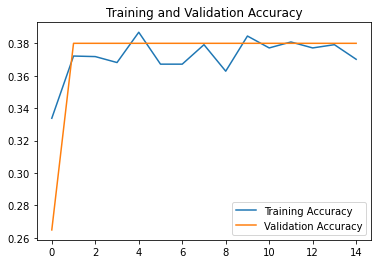

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


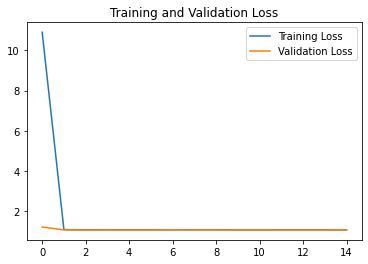

<Figure size 432x288 with 0 Axes>

In [26]:
path_weight = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/efficientnet/noisy-student/notop/efficientnet-l2_noisy-student_notop.h5'
with strategy.scope():
    effl2_model = EfficientNetL2(pooling='avg', 
                                 weights=path_weight, 
                                 include_top=False, 
                                 input_shape=(IMG_SIZE,IMG_SIZE,3),
                                 drop_connect_rate=0)
    for layers in effl2_model.layers:
                layers.trainable=False

    last_layer = effl2_model.get_layer('avg_pool')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    effl2_x = Flatten()(last_output)
    effl2_x = Dense(1024, activation = 'relu')(effl2_x)
    effl2_x = Dropout(0.2)(effl2_x)
    effl2_x = Dense(3, activation = 'softmax')(effl2_x)
    effl2_final_model = Model(effl2_model.input, effl2_x)
    effl2_final_model.compile(loss = 'categorical_crossentropy',
                              optimizer= 'adam', 
                              metrics=['acc'])

# EFFL2
effl2_final_model.summary()

since = time.time()
effl2_history = effl2_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effl2_history, 'effl2_model')

In [27]:
effl2_final_model.evaluate(test_generator)
effl2_best_model = effl2_final_model

11/11 [==============================] - 72s 7s/step - loss: 1.0823 - acc: 0.3795


## Combining Similar Model 

In [28]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_vgg_pred = []
combined_resnet_pred = []
combined_effnet_pred = []
vgg16_pred = []
resnet101_pred = []
effnetb7_pred = []
vgg19_pred = []
resnet101v2_pred = []
effnetl2_pred = []
for folder in os.listdir(val_folders):
    
    val_image_ids = os.listdir(os.path.join(val_folders,folder))
    
    for image_id in val_image_ids[:int(len(val_image_ids))]:
        
        path = os.path.join(val_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
        img_normalized = img/IMG_SIZE
        
        #vgg16
        vgg16_image_prediction = np.argmax(vgg16_best_model.predict(np.array([img_normalized])))
        vgg16_pred.append(vgg16_image_prediction)
        
        #resnet101
        resnet101_image_prediction = np.argmax(resnet101_best_model.predict(np.array([img_normalized])))
        resnet101_pred.append(resnet101_image_prediction)
        
        #effnetb7
        effnetb7_image_prediction = np.argmax(effb7_best_model.predict(np.array([img_normalized])))
        effnetb7_pred.append(effnetb7_image_prediction)
        
        #vgg19
        vgg19_image_prediction = np.argmax(vgg19_best_model.predict(np.array([img_normalized])))
        vgg19_pred.append(vgg19_image_prediction)
        
        #resnet101v2
        resnet101v2_image_prediction = np.argmax(resnet101v2_best_model.predict(np.array([img_normalized])))
        resnet101v2_pred.append(resnet101v2_image_prediction)
        
        #effnetl2
        effnetl2_image_prediction = np.argmax(effl2_best_model.predict(np.array([img_normalized])))
        effnetl2_pred.append(effnetl2_image_prediction)
        
        #combine_vgg
        image_prediction = mode([vgg19_image_prediction, vgg16_image_prediction])                                  
        combined_vgg_pred.append(image_prediction)
        
        #combine_resnet
        image_prediction = mode([resnet101v2_image_prediction, resnet101_image_prediction])                                  
        combined_resnet_pred.append(image_prediction)
        
        #combine_efficientnet
        image_prediction = mode([effnetb7_image_prediction, effnetl2_image_prediction])                                  
        combined_effnet_pred.append(image_prediction)

## Define Classification

In [29]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

## Result of Classification

Model Accuracy 0.7881619937694704
              precision    recall  f1-score   support

       focal       0.83      0.68      0.75       170
      normal       0.71      0.96      0.82       244
   sclerosed       0.90      0.69      0.78       228

    accuracy                           0.79       642
   macro avg       0.81      0.77      0.78       642
weighted avg       0.81      0.79      0.79       642



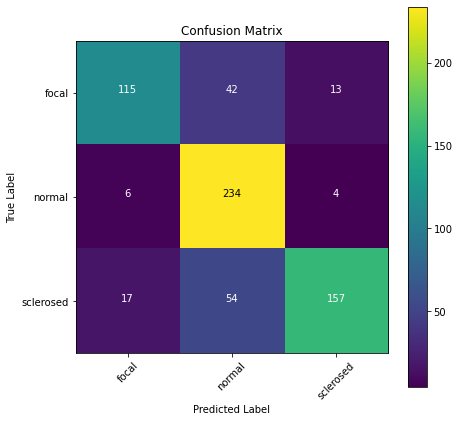

In [30]:
#combined vgg
combined_vgg_pred = [ c[0] for c in combined_vgg_pred]
clf_report(true_value, combined_vgg_pred)

Model Accuracy 0.822429906542056
              precision    recall  f1-score   support

       focal       0.77      0.88      0.82       170
      normal       0.77      0.92      0.84       244
   sclerosed       0.99      0.68      0.80       228

    accuracy                           0.82       642
   macro avg       0.84      0.82      0.82       642
weighted avg       0.85      0.82      0.82       642



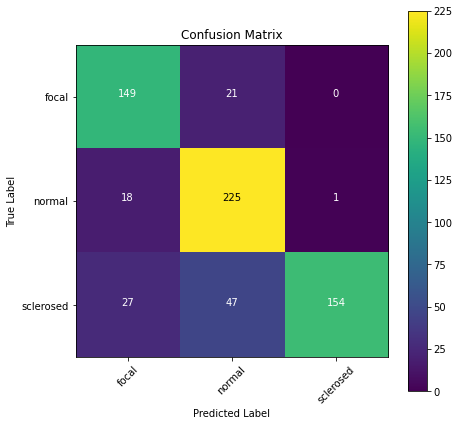

In [31]:
#combined resnet
combined_resnet_pred = [ c[0] for c in combined_resnet_pred]
clf_report(true_value, combined_resnet_pred)

Model Accuracy 0.8722741433021807
              precision    recall  f1-score   support

       focal       0.80      0.92      0.86       170
      normal       0.88      0.85      0.87       244
   sclerosed       0.93      0.86      0.89       228

    accuracy                           0.87       642
   macro avg       0.87      0.88      0.87       642
weighted avg       0.88      0.87      0.87       642



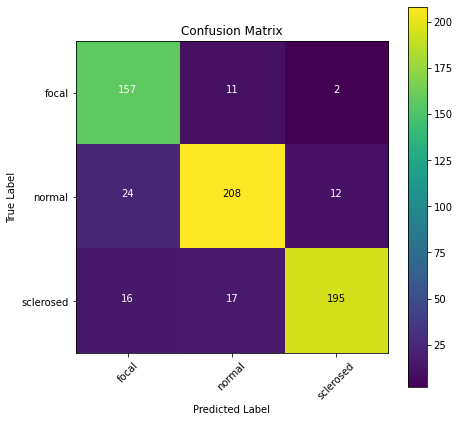

In [32]:
#combined effnet
combined_effnet_pred = [ c[0] for c in combined_effnet_pred]
clf_report(true_value, combined_effnet_pred)

Model Accuracy 0.838006230529595
              precision    recall  f1-score   support

       focal       0.85      0.79      0.82       170
      normal       0.80      0.88      0.83       244
   sclerosed       0.88      0.83      0.86       228

    accuracy                           0.84       642
   macro avg       0.84      0.83      0.84       642
weighted avg       0.84      0.84      0.84       642



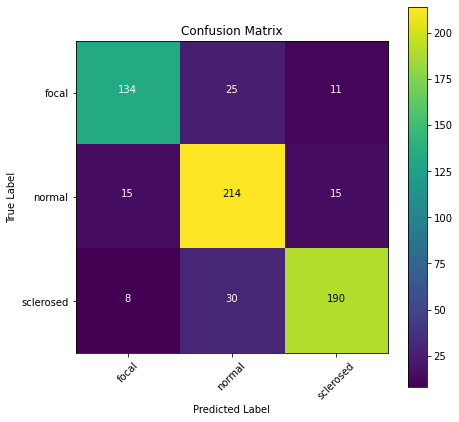

In [33]:
# VGG16 model classification report
clf_report(true_value, vgg16_pred)

Model Accuracy 0.7881619937694704
              precision    recall  f1-score   support

       focal       0.83      0.68      0.75       170
      normal       0.71      0.96      0.82       244
   sclerosed       0.90      0.69      0.78       228

    accuracy                           0.79       642
   macro avg       0.81      0.77      0.78       642
weighted avg       0.81      0.79      0.79       642



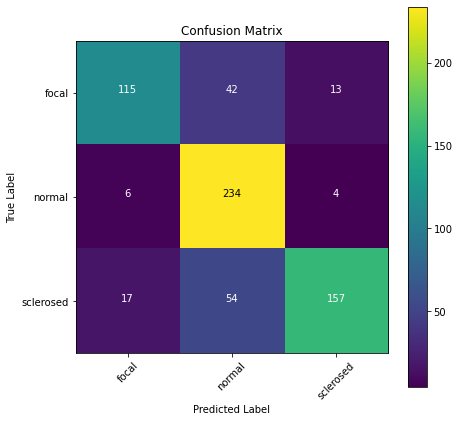

In [34]:
# VGG19 model classification report
clf_report(true_value, vgg19_pred)

Model Accuracy 0.8161993769470405
              precision    recall  f1-score   support

       focal       0.76      0.84      0.80       170
      normal       0.93      0.74      0.83       244
   sclerosed       0.77      0.88      0.82       228

    accuracy                           0.82       642
   macro avg       0.82      0.82      0.81       642
weighted avg       0.83      0.82      0.82       642



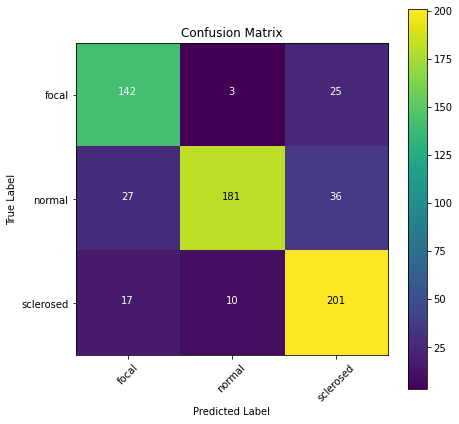

In [35]:
# Resnet50 model classification report
clf_report(true_value, resnet101_pred)

Model Accuracy 0.822429906542056
              precision    recall  f1-score   support

       focal       0.77      0.88      0.82       170
      normal       0.77      0.92      0.84       244
   sclerosed       0.99      0.68      0.80       228

    accuracy                           0.82       642
   macro avg       0.84      0.82      0.82       642
weighted avg       0.85      0.82      0.82       642



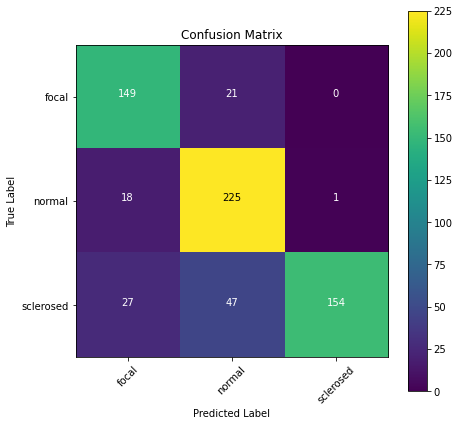

In [36]:
# Resnet50v2 model classification report
clf_report(true_value, resnet101v2_pred)

Model Accuracy 0.8722741433021807
              precision    recall  f1-score   support

       focal       0.80      0.92      0.86       170
      normal       0.88      0.85      0.87       244
   sclerosed       0.93      0.86      0.89       228

    accuracy                           0.87       642
   macro avg       0.87      0.88      0.87       642
weighted avg       0.88      0.87      0.87       642



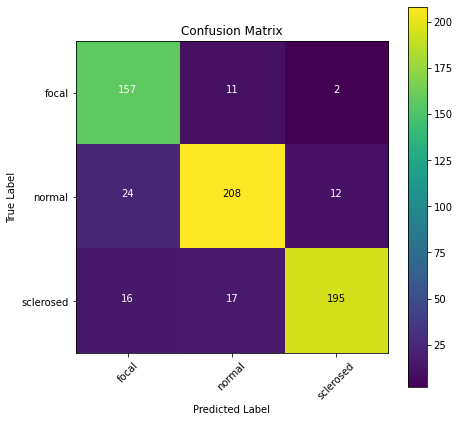

In [37]:
# EfficientNetB7 model classification report
clf_report(true_value, effnetb7_pred)

Model Accuracy 0.38006230529595014
              precision    recall  f1-score   support

       focal       0.00      0.00      0.00       170
      normal       0.38      1.00      0.55       244
   sclerosed       0.00      0.00      0.00       228

    accuracy                           0.38       642
   macro avg       0.13      0.33      0.18       642
weighted avg       0.14      0.38      0.21       642



/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


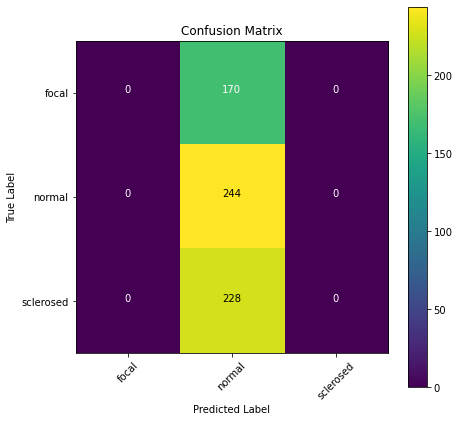

In [38]:
# EfficientNetL2 model classification report
clf_report(true_value, effnetl2_pred)

## Display Prediction Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


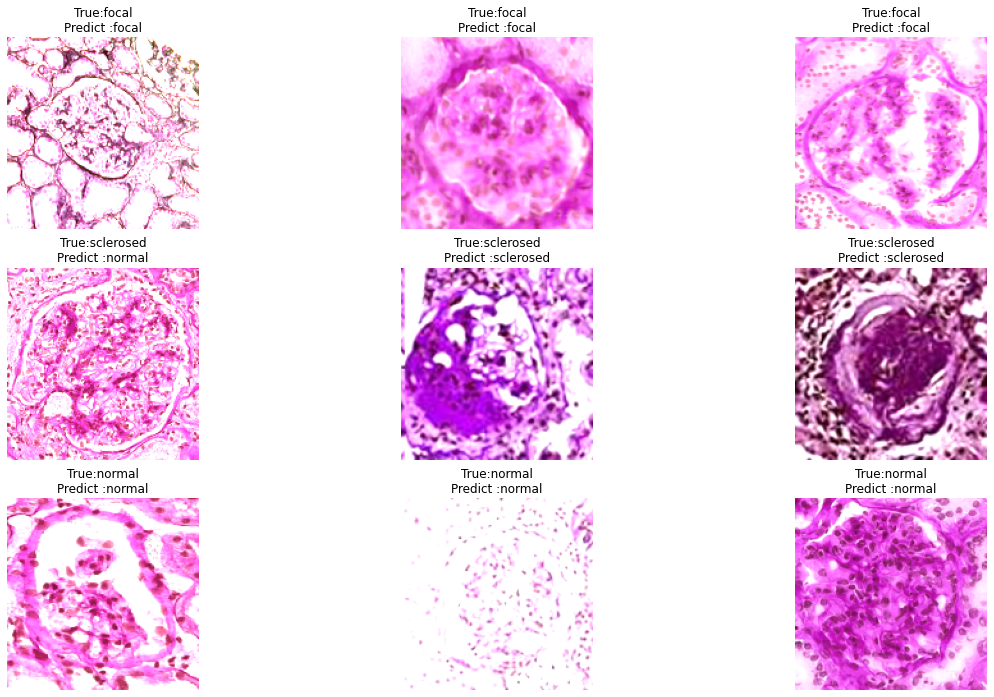

In [39]:
show_few_images(3,vgg16_best_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


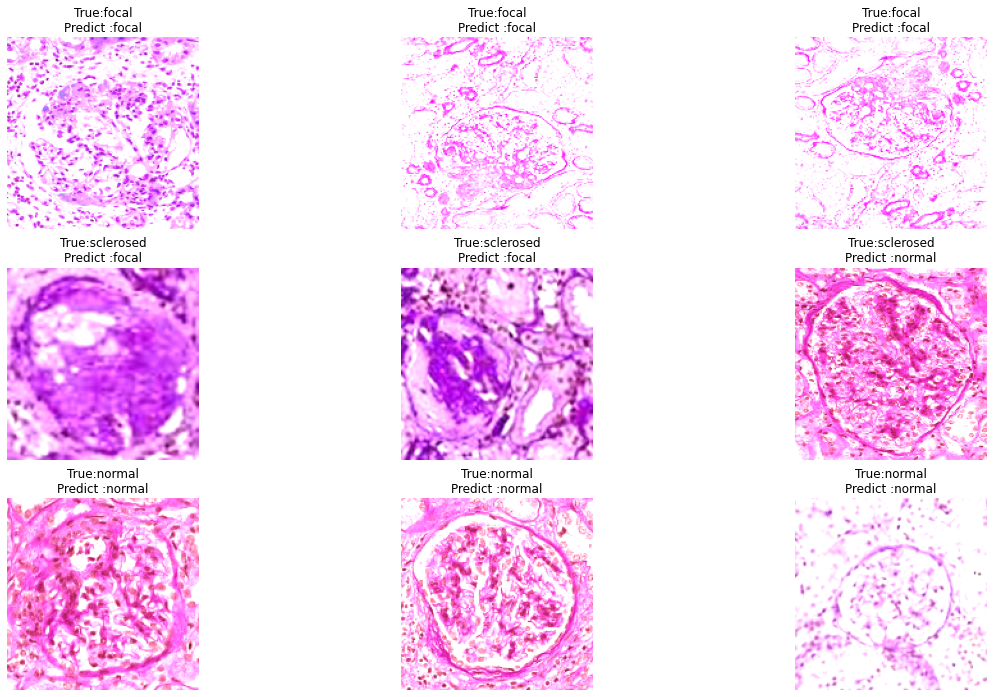

In [40]:
show_few_images(3,vgg19_best_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


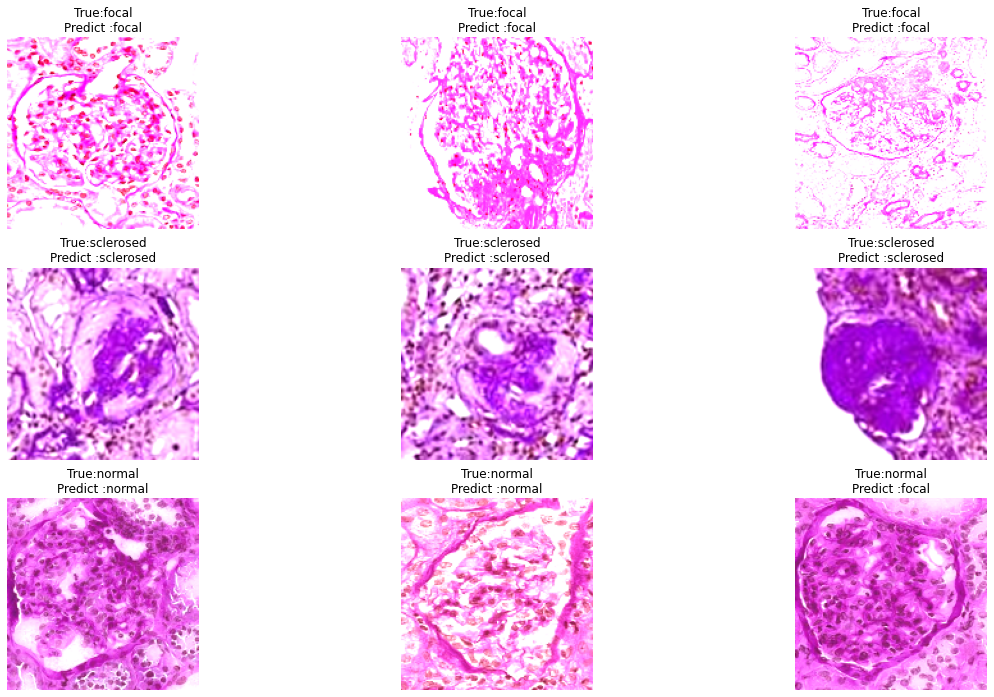

In [41]:
show_few_images(3,resnet101_best_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


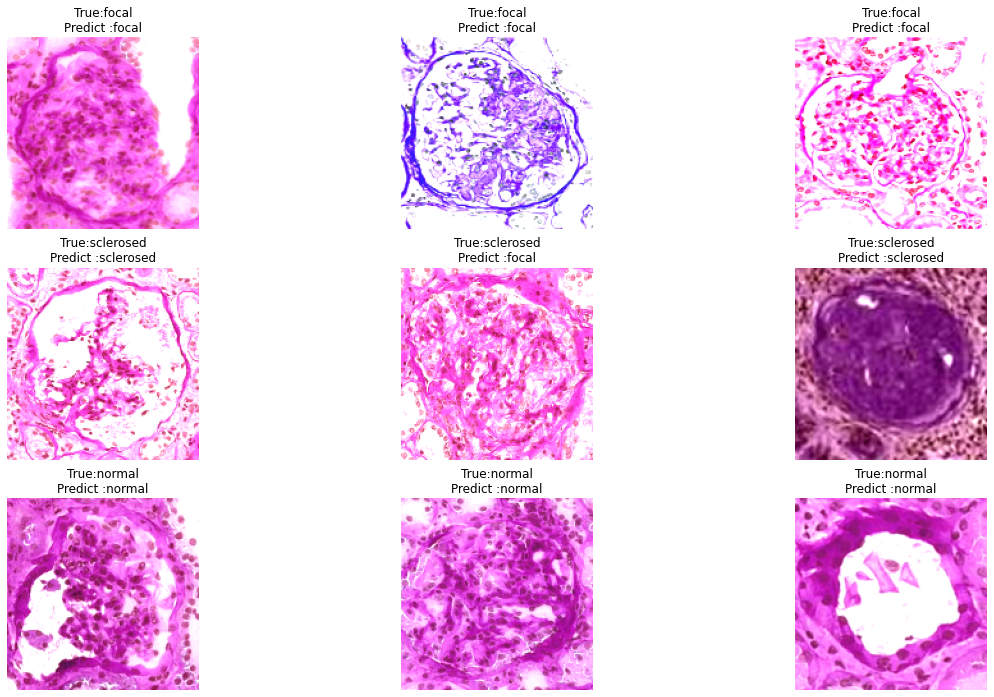

In [42]:
show_few_images(3,resnet101v2_best_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


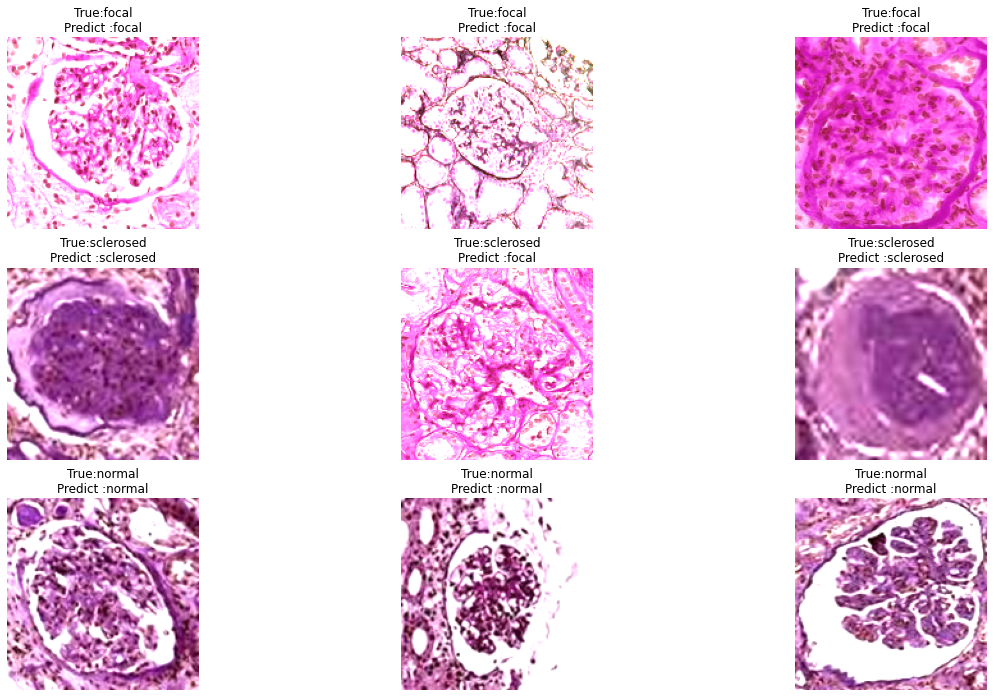

In [43]:
show_few_images(3,effb7_best_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


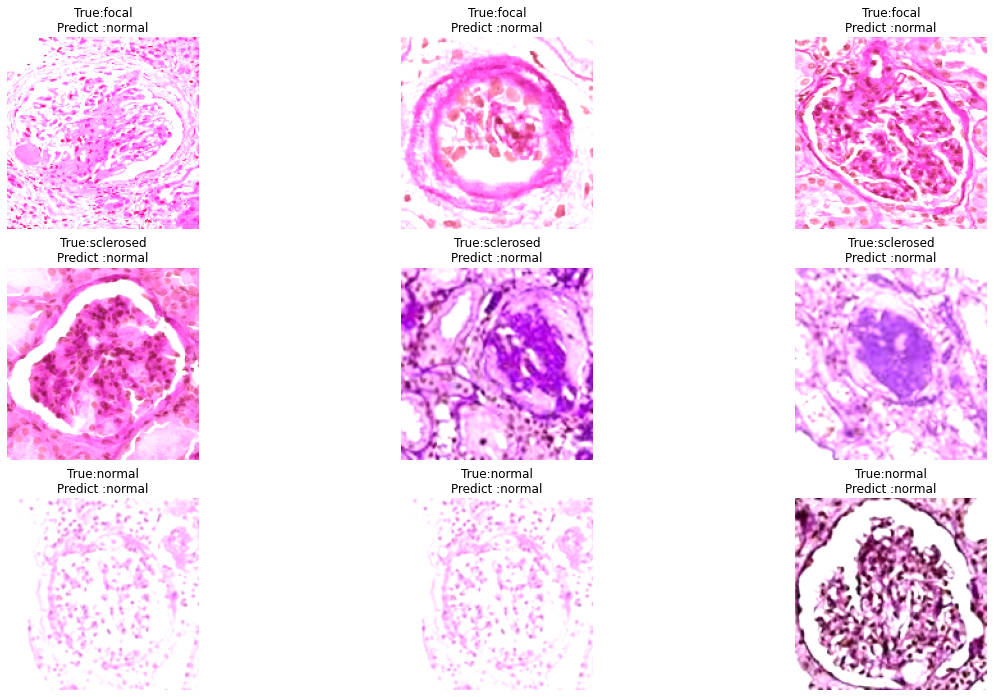

In [44]:
show_few_images(3,effl2_best_model)